* Import libraries 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

* Load and read, and combine the two datasets

In [2]:
df1 = pd.read_csv('data/train.csv')
df2 = pd.read_csv('data/youtoxic.csv')

In [3]:
# Process df1
df1['Toxic'] = df1.iloc[:, 2:].any(axis=1)
df1_processed = df1[['comment_text', 'Toxic']].rename(columns={'comment_text': 'Text'})

# Process df2
df2['Toxic'] = df2.iloc[:, 3:].any(axis=1)
df2_processed = df2[['Text', 'Toxic']]

# Combine df1_processed and df2_processed
df = pd.concat([df1_processed, df2_processed], ignore_index=True)

# Display the first few rows of final_df
print(df.head())

                                                Text  Toxic
0  Explanation\nWhy the edits made under my usern...  False
1  D'aww! He matches this background colour I'm s...  False
2  Hey man, I'm really not trying to edit war. It...  False
3  "\nMore\nI can't make any real suggestions on ...  False
4  You, sir, are my hero. Any chance you remember...  False


In [4]:
df.describe()

,Text,Toxic
count,160571,160571
unique,160568,2
top,run them over,False
freq,3,143884


* The Text column has 160,571 entries, 3 of which are duplicates.

* The Toxic column has 160,571 entries, with False being the most common value, appearing 143,884 times.

* Check data types and missing values

In [5]:
# Check data types and missing values
print(df.dtypes)
print(df.isnull().sum())

Text     object
Toxic      bool
dtype: object
Text     0
Toxic    0
dtype: int64


* Text column is categorical and Toxic column is boolean

* There are no missing values in either column.

* Check for duplicate comments

In [6]:
# Check for duplicate comments
duplicate_rows = df[df.duplicated(subset=['Text'], keep=False)]
print("Duplicate rows based on 'Text' column:")
print(duplicate_rows)

Duplicate rows based on 'Text' column:
                 Text  Toxic
160163  RUN THEM OVER   True
160213  run them over   True
160228  run them over   True
160248  run them over   True
160270  RUN THEM OVER   True


* A comment, run them over, is duplicated.

* Remove duplicates from the dataset and confirm the removal.

In [7]:
# Drop duplicate comments
df.drop_duplicates(subset=['Text'], keep='first', inplace=True)

# Confirm duplicates are removed
print("Number of rows after removing duplicates:", len(df))

Number of rows after removing duplicates: 160568


* Reindex the DataFrame after dropping duplicates

In [8]:
# Reindex the DataFrame after dropping duplicates
df.reset_index(drop=True, inplace=True)

* Check the distribution of 'Toxic' column

In [9]:
# Distribution of 'Toxic' column
toxic_distribution = df['Toxic'].value_counts()
print(toxic_distribution)

Toxic
False    143884
True      16684
Name: count, dtype: int64


* Visualise the distribution of comments, 'Toxic', column with bar plot

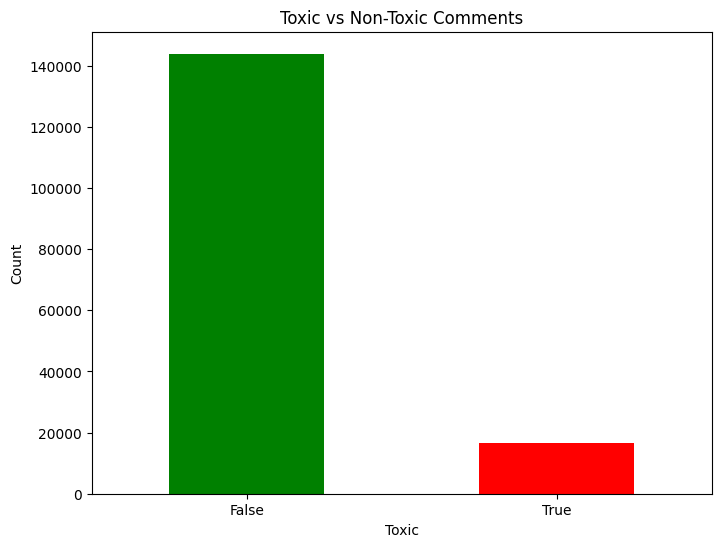

In [10]:
# Bar plot for toxic vs non-toxic comments
plt.figure(figsize=(8, 6))
toxic_counts = df['Toxic'].value_counts()
toxic_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Toxic vs Non-Toxic Comments')
plt.xlabel('Toxic')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

* There is a marked class imbalance. The positive comments are far more numerous than the negative ones, at a rate of almost nine positive comments to one negative comment.

* So the imbalance needs to be addressed to ensure a more accurate and fair analysis of the data and to improve the performance and reliability of the model during the model building process.

* Visualise the common words in toxic and non-toxic comments with Word cloud.

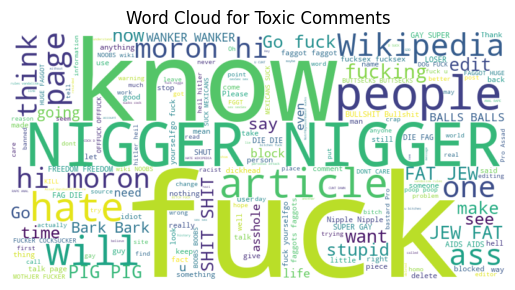

In [11]:
# Word Cloud for toxic and non-toxic comments
toxic_comments = ' '.join(df[df['Toxic']]['Text'])
wordcloud_toxic = WordCloud(width=800, height=400, background_color='white').generate(toxic_comments)
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Toxic Comments')
plt.show()

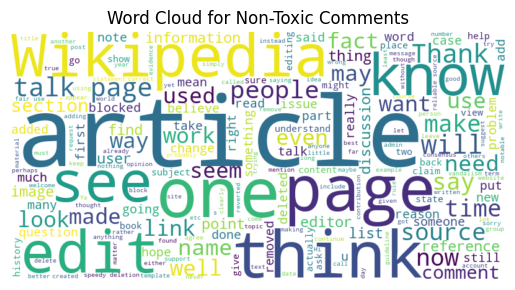

In [12]:
non_toxic_comments = ' '.join(df[~df['Toxic']]['Text'])
wordcloud_non_toxic = WordCloud(width=800, height=400, background_color='white').generate(non_toxic_comments)
plt.imshow(wordcloud_non_toxic, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Non-Toxic Comments')
plt.show()

* Transformation of Data

1. Data Cleaning

In [13]:
# Convert True to 1 and False to 0 in the 'Toxic' column
df['Toxic'] = df['Toxic'].astype(int)

# Clean the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text
# clean the comment_text in train_df [Thanks to Pulkit Jha for the useful pointer.]
df['Text'] = df['Text'].map(lambda com : clean_text(com))

df.head()

<>:17: SyntaxWarning: invalid escape sequence '\W'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\W'
<>:18: SyntaxWarning: invalid escape sequence '\s'
C:\Users\walea\AppData\Local\Temp\ipykernel_35924\1763633203.py:17: SyntaxWarning: invalid escape sequence '\W'
  text = re.sub('\W', ' ', text)
C:\Users\walea\AppData\Local\Temp\ipykernel_35924\1763633203.py:18: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)


,Text,Toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i am s...,0
2,hey man i am really not trying to edit war it ...,0
3,more i cannot make any real suggestions on imp...,0
4,you sir are my hero any chance you remember wh...,0


2. Vectorization: Convert raw textual data into vectors that ml models can can process and learn from

*  TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer is considered for this task

In [14]:
# Vectorize the text data using TF-IDF
vect = TfidfVectorizer(max_features=5000, stop_words='english')
X = vect.fit_transform(df['Text'])
Y = df['Toxic']

In [15]:
print(X)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3189564 stored elements and shape (160568, 5000)>
  Coords	Values
  (0, 1809)	0.2050716965890807
  (0, 1643)	0.14570513334514076
  (0, 4731)	0.20989552822585966
  (0, 2190)	0.3011514323074402
  (0, 1867)	0.22806849195621118
  (0, 3880)	0.1763884808146868
  (0, 2586)	0.1067193199706631
  (0, 2059)	0.27150923739892324
  (0, 4820)	0.2639748478761683
  (0, 3060)	0.14311205787510659
  (0, 4986)	0.2309620854714083
  (0, 1832)	0.26599045731542253
  (0, 3784)	0.16355577908656588
  (0, 4475)	0.1861042394214054
  (0, 4438)	0.09973826900365435
  (0, 3244)	0.09859306675128376
  (0, 3867)	0.2740138391684794
  (0, 274)	0.2651705465582075
  (0, 157)	0.2841406677467057
  (0, 214)	0.2519847779221846
  (0, 201)	0.22088423925813824
  (1, 4438)	0.12978705871132476
  (1, 2856)	0.3379038451501234
  (1, 655)	0.28597469898047395
  (1, 1077)	0.3715727397199104
  :	:
  (160564, 4911)	0.2474599362214298
  (160564, 3512)	0.16075332756464358
  (160564, 

* Addressing Class Imbalance with SMOTE

* To handle this imbalance, we can use techniques like oversampling the minority class or undersampling the majority class. However, since the dataset is a bit small, undersampling may not be the best approach. Instead, we can use techniques like Synthetic Minority Over-sampling Technique (SMOTE) to balance the classes.

In [16]:
# Import SMOTE from imblearn
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE()

# Apply SMOTE for oversampling
X_resampled, y_resampled = smote.fit_resample(X, Y)\


# Convert the oversampled data back to a DataFrame
df_resampled = pd.DataFrame(X_resampled.todense(), columns=vect.get_feature_names_out())
df_resampled['Toxic'] = y_resampled



Distribution after SMOTE:
Toxic
0    143884
1    143884
Name: count, dtype: int64


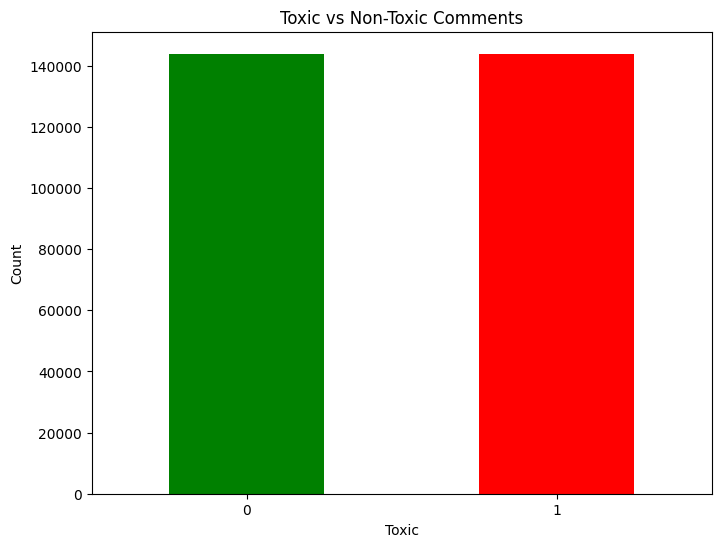

In [17]:
# Check the distribution after oversampling
toxic_distribution_after = df_resampled['Toxic'].value_counts()
print("\nDistribution after SMOTE:")
print(toxic_distribution_after)

# Bar plot for toxic vs non-toxic comments
plt.figure(figsize=(8, 6))
toxic_counts = df_resampled['Toxic'].value_counts()
toxic_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Toxic vs Non-Toxic Comments')
plt.xlabel('Toxic')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

* Modelling

1. Split the the resampled data into training and test sets

In [18]:
# Split the resampled data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

2. Instantiate the deep learning model

*   A lightweight model, such as a simple neural network with an input layer, a hidden layer containing 64 neurons, and an output layer with a sigmoid activation function for binary classification, uses a dropout rate of 0.5 to help prevent overfitting. The model is optimized using the Adam optimizer with a learning rate of 0.001.

In [19]:
# Build the neural network model with Input layer
model = Sequential([
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

* Train the model using 10 epoch, batch size of 32 and validation split of 0.2

In [20]:
# Train the model
history = model.fit(x_train.toarray(), y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
5756/5756 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - accuracy: 0.8910 - loss: 0.3047 - val_accuracy: 0.9330 - val_loss: 0.1770
Epoch 2/10
5756/5756 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.9392 - loss: 0.1631 - val_accuracy: 0.9449 - val_loss: 0.1480
Epoch 3/10
5756/5756 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.9545 - loss: 0.1288 - val_accuracy: 0.9559 - val_loss: 0.1260
Epoch 4/10
5756/5756 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - accuracy: 0.9645 - loss: 0.1053 - val_accuracy: 0.9620 - val_loss: 0.1101
Epoch 5/10
5756/5756 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - accuracy: 0.9720 - loss: 0.0868 - val_accuracy: 0.9663 - val_loss: 0.0999
Epoch 6/10
5756/5756 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.9764 - loss: 0.0747 - val_accuracy: 0.9699 - val_loss: 0.0915
Epoch 7/10
5756/5756 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9798 - loss: 0.0663 - val_accuracy: 0.9718 - val_loss: 0.0867
Epoch 8/10
5756/5756 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9813 - loss: 0

* Visualize the history to see the training and validation accuracy and loss.

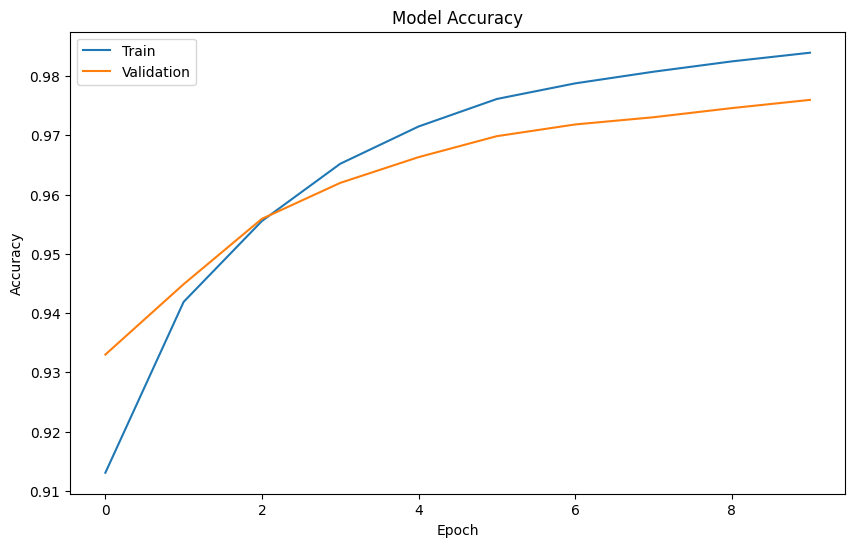

In [21]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

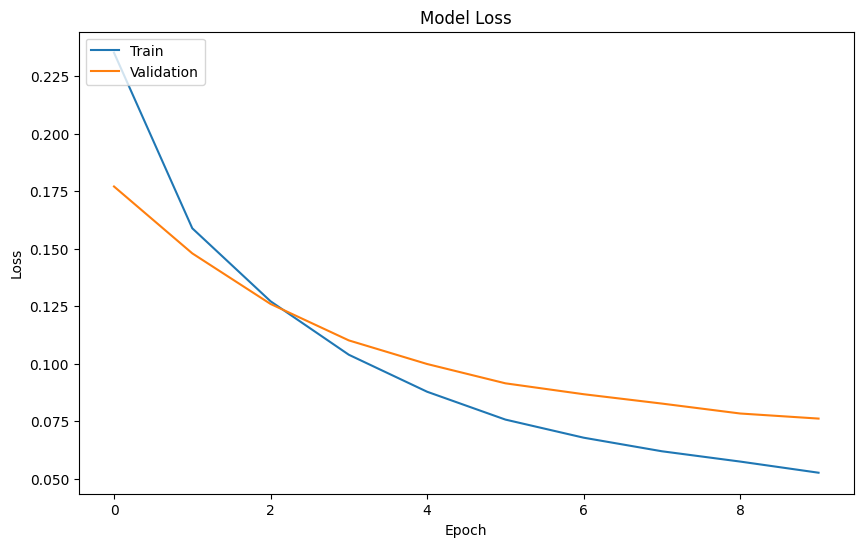

In [22]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* Model Evaluation on the test dataset

1. Accuracy

In [23]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy}')

1799/1799 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9751 - loss: 0.0799
Test Accuracy: 0.9755186438560486


2. Generate predictions

In [24]:
# Generate predictions on the test set
y_pred_proba = model.predict(x_test)
y_pred = (y_pred_proba > 0.5).astype(int)

1799/1799 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


3. Classification report

In [25]:
# Generate classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     28665
           1       0.96      0.99      0.98     28889

    accuracy                           0.98     57554
   macro avg       0.98      0.98      0.98     57554
weighted avg       0.98      0.98      0.98     57554



* Visualise the classification report for better visualization

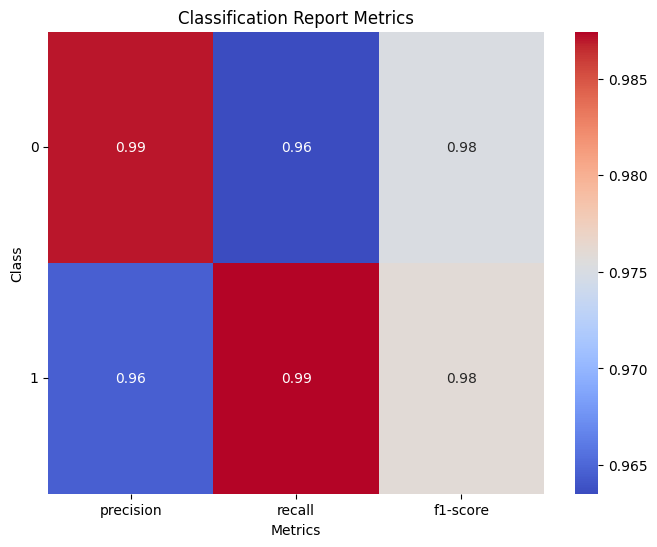

In [26]:
# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Extract relevant metrics for visualization
class_metrics = df_report.drop(['accuracy', 'macro avg', 'weighted avg'])

# Plotting the classification report metrics using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(class_metrics[['precision', 'recall', 'f1-score']], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Classification Report Metrics')
plt.xlabel('Metrics')
plt.ylabel('Class')
plt.yticks(rotation=0)
plt.show()

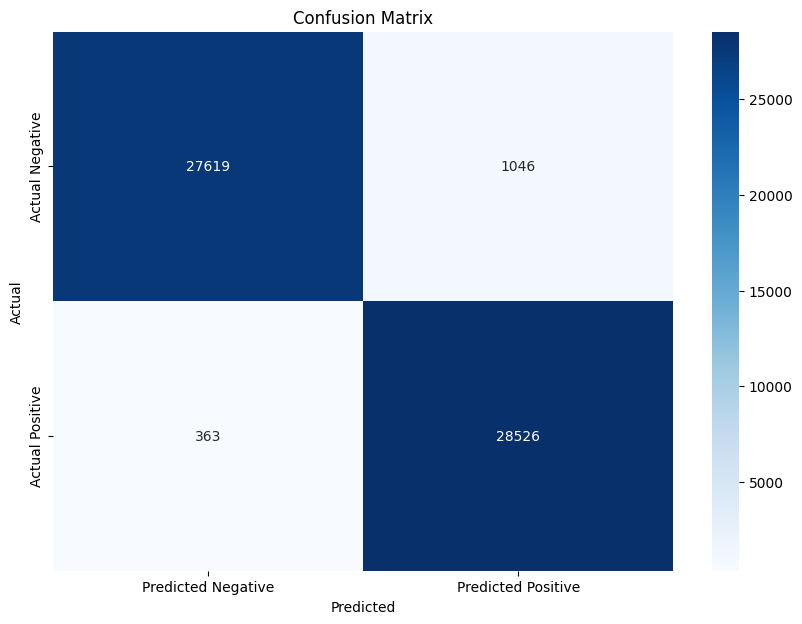

In [27]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 
                         'Predicted Positive'], 
            yticklabels=['Actual Negative', 
                         'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

* Save the vectorizer and model for future use

In [29]:
import pickle
import os

# Ensure the 'models' directory exists
os.makedirs('models', exist_ok=True)

# Save the TF-IDF vectorizer
with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vect, f)

# Save the Keras model
model.save('models/toxic_comment_model.keras')

* Load the saved keras model and Vectorizer to make a prediction on comments

In [30]:
from tensorflow.keras.models import load_model
from sklearn.feature_extraction.text import TfidfVectorizer

# Load TF-IDF Vectorizer
with open('models/tfidf_vectorizer.pkl', 'rb') as f:
    loaded_vect = pickle.load(f)

# Load Trained Model
loaded_model = load_model('models/toxic_comment_model.keras')

c:\Users\walea\miniconda3\envs\toxic\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


* New Comments

In [31]:
new_comments = [
    "I love this website, it's so helpful!",
    "This is the worst product ever, total waste of money.",
    "The author of this article is brilliant!",
    "This software is a scam, do not buy it.",
    "The customer service was excellent, very helpful and friendly.",
]


* Preprocess the new_comments with the loaded TF-IDF Vectorizer

In [33]:
# Preprocess new comments using the loaded TF-IDF Vectorizer
new_comments_vectors = loaded_vect.transform(new_comments)

* Make and print predictions with the loaded model

In [34]:
# Predict using the loaded model
predictions = (loaded_model.predict(new_comments_vectors) > 0.5).astype(int)

# Print predictions
for comment, prediction in zip(new_comments, predictions):
    print(f'Comment: {comment} | Toxic: {bool(prediction)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Comment: I love this website, it's so helpful! | Toxic: False
Comment: This is the worst product ever, total waste of money. | Toxic: True
Comment: The author of this article is brilliant! | Toxic: False
Comment: This software is a scam, do not buy it. | Toxic: False
Comment: The customer service was excellent, very helpful and friendly. | Toxic: False


In [49]:
import pickle
from tensorflow.keras.models import load_model
import numpy as np

# Load the saved TF-IDF Vectorizer
with open('models/tfidf_vectorizer.pkl', 'rb') as f:
    loaded_vect = pickle.load(f)

# Load the saved Keras model
loaded_model = load_model('models/toxic_comment_model.keras')

# List of comments to be classified
comments = [
    "I love this product! It has made my life so much easier.",
    "The customer service was terrible. I'll never shop here again.",
    "This article was very informative and well-written. Thanks for sharing!",
    "I can't believe how fast the shipping was. Highly recommend this seller.",
    "The app keeps crashing every time I try to open it. Please fix it.",
    "Great tutorial! I was able to follow along and complete the project.",
    "This place has the best coffee in town. I visit every morning.",
    "I'm really disappointed with the quality of this item. It broke after one use.",
    "Thanks for the advice! It really helped me with my problem.",
    "I had a wonderful experience at this restaurant. The food was delicious and the staff was friendly.",
]

# Preprocess comments using the loaded TF-IDF Vectorizer
comments_vectors = loaded_vect.transform(comments)

# Predict using the loaded model
predictions = (loaded_model.predict(comments_vectors) > 0.5).astype(int)

# Print predictions
for comment, prediction in zip(comments, predictions):
    print(f'Comment: {comment} | Toxic: {bool(prediction[0])}')


c:\Users\walea\miniconda3\envs\toxic\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Comment: I love this product! It has made my life so much easier. | Toxic: False
Comment: The customer service was terrible. I'll never shop here again. | Toxic: False
Comment: This article was very informative and well-written. Thanks for sharing! | Toxic: False
Comment: I can't believe how fast the shipping was. Highly recommend this seller. | Toxic: False
Comment: The app keeps crashing every time I try to open it. Please fix it. | Toxic: False
Comment: Great tutorial! I was able to follow along and complete the project. | Toxic: False
Comment: This place has the best coffee in town. I visit every morning. | Toxic: False
Comment: I'm really disappointed with the quality of this item. It broke after one use. | Toxic: False
Comment: Thanks for the advice! It really helped me with my problem. | Toxic: False
Comment: I had a wonderful experience at this restaurant. The food was delicious and the staff was friendly. | Toxic: False


True
